In [7]:
from sklearn.datasets import make_regression, make_classification, make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import gpflow as gpf
import time

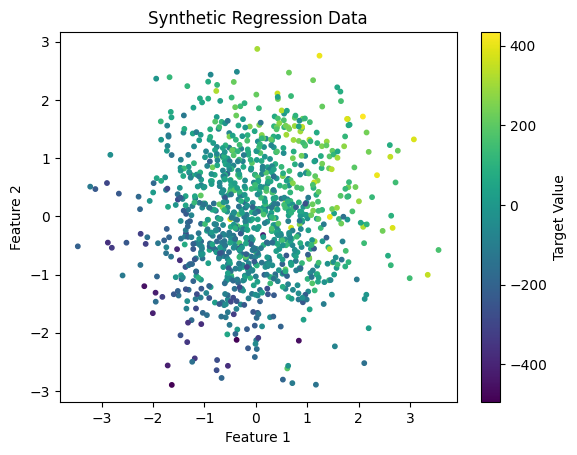

In [8]:
# Generate synthetic regression data
n_samples, n_features, noise = 1000, 5, 0.1
X, y = make_regression(n_samples=n_samples, n_features=5)

# Plot the first two dimensions of the data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=10)
plt.title('Synthetic Regression Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Target Value')
plt.show()

In [9]:
# Function to estimate memory usage in bytes for the GP model components
def estimate_memory_usage(n_samples, n_features, model_type, n_inducing=None):
    # Memory for dataset (X_train and y_train)
    dataset_memory = n_samples * n_features * 8 + n_samples * 8  # X_train + y_train (float64, 8 bytes per float)

    if model_type == "GPR":
        # Full GP: Covariance matrix is N x N
        covariance_matrix_memory = n_samples ** 2 * 8  # N x N matrix, 8 bytes per float
    elif model_type == "SGPR":
        # Sparse GP: Covariance matrix is M x M (inducing points)
        if n_inducing is None:
            raise ValueError("n_inducing must be provided for SGPR")
        covariance_matrix_memory = n_inducing ** 2 * 8  # M x M matrix, 8 bytes per float
    
    # Memory for kernel parameters and gradients (assume around 1 KB for kernel + gradients)
    kernel_and_gradients_memory = 1024  # Rough estimation

    # Total memory usage estimate
    total_memory = dataset_memory + covariance_matrix_memory + kernel_and_gradients_memory

    return total_memory / (1024 ** 2)  # Convert to MB

In [10]:
import time
import numpy as np
import gpflow as gpf
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression

# Callback function to count iterations
class IterationCallback:
    def __init__(self):
        self.iteration_count = 0
    
    # Accept additional arguments but ignore them
    def __call__(self, step, variables=None, values=None, *args, **kwargs):
        self.iteration_count += 1


# Function to train a GP model and return the RMSE, average uncertainty, time taken, and iteration count
def train_and_evaluate_gp(n_samples, model, Kernel):
    # Generate synthetic regression data
    X, y = make_regression(n_samples=n_samples, n_features=1, noise=0.1)  # n_features=1 for plotting
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Convert to TensorFlow tensors
    X_train = tf.convert_to_tensor(X_train, dtype=tf.float64)
    y_train = tf.convert_to_tensor(y_train.reshape(-1, 1), dtype=tf.float64)  # Make y_train a column vector
    
    # Create a GP regression model with an RBF kernel
    if model == "GPR":
        model = gpf.models.GPR(data=(X_train, y_train), kernel=Kernel, mean_function=None)
    elif model == "SGPR":
        inducing_variables = tf.gather(X_train, tf.random.shuffle(tf.range(tf.shape(X_train)[0]))[:tf.shape(X_train)[0] // 10])
        model = gpf.models.SGPR(data=(X_train, y_train), kernel=Kernel, inducing_variable=inducing_variables, mean_function=None)
        gpf.config.set_default_jitter(1e-6)

    
    # Create iteration callback to count the number of optimization steps
    iteration_callback = IterationCallback()
    
    # Measure the time taken to optimize (which includes matrix inversion)
    start_time = time.time()
    
    # Optimize the model's parameters with a callback to count iterations
    opt = gpf.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables, step_callback=iteration_callback)
    
    end_time = time.time()
    
    # Time taken for matrix inversion and optimization
    time_taken = end_time - start_time
    
    # Make predictions on the test set
    X_test = tf.convert_to_tensor(X_test, dtype=tf.float64)
    mean, variance = model.predict_f(X_test)
    
    # Convert predictions to NumPy arrays
    mean_np = mean.numpy().flatten()
    variance_np = variance.numpy().flatten()
    y_test_np = y_test.flatten()
    
    # Compute RMSE
    rmse = np.sqrt(np.mean((mean_np - y_test_np) ** 2))
    
    # Compute average uncertainty (standard deviation)
    avg_uncertainty = np.mean(np.sqrt(variance_np))
    
    # Return RMSE, average uncertainty, time taken, and iteration count
    return rmse, avg_uncertainty, time_taken, iteration_callback.iteration_count


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import psutil
import time

# Utility to get memory usage
def get_memory_usage():
    process = psutil.Process()
    mem_info = process.memory_info()
    return mem_info.rss / (1024 ** 2)  # Return memory usage in MB

# General function to run comparison for multiple GP models
def run_comparison(max_samples, models_kernels):
    start = 500
    step = 500
    dataset_sizes = np.arange(start, max_samples + 1, step)
    print(max(dataset_sizes))

    # Dictionary to store results for each model
    results = {
        'times': {},
        'uncertainties': {},
        'memory_usages': {},
        'iterations': {}
    }

    # Loop over each model and its kernel
    for model_name, model_kernel in models_kernels:
        times = []
        uncertainties = []  
        memory_usages = []
        iterations = []

        for idx, size in enumerate(dataset_sizes):
            rmse, avg_uncertainty, time_taken, n_iter = train_and_evaluate_gp(size, model_name, model_kernel)
            memory = estimate_memory_usage(n_samples=size, n_features=n_features, model_type=model_name, n_inducing=0.1*size)
            
            uncertainties.append(avg_uncertainty)
            times.append(time_taken)
            memory_usages.append(memory)
            iterations.append(n_iter)
            
            print(f"Model: {model_name}, Dataset size: {size}, Time: {time_taken:.4f} seconds, "
                  f"Memory: {memory:.2f} MB, Iterations: {n_iter}, "
                  f"Uncertainty: {avg_uncertainty:.4f}")
        
        # Store results for this model
        results['times'][model_name] = times
        results['uncertainties'][model_name] = uncertainties
        results['memory_usages'][model_name] = memory_usages
        results['iterations'][model_name] = iterations

    # Plotting the results
    plt.figure(figsize=(10, 12))

    # Time Plot
    plt.subplot(4, 1, 1)
    for model_name in results['times']:
        plt.plot(dataset_sizes, results['times'][model_name], 'o-', label=f'{model_name} Time')
    plt.title('Performance Metrics vs Dataset Size')
    plt.ylabel('Time (seconds)')
    plt.xscale('log')
    plt.grid(True)
    plt.legend()

    # Memory Usage Plot
    plt.subplot(4, 1, 2)
    for model_name in results['memory_usages']:
        plt.plot(dataset_sizes, results['memory_usages'][model_name], 'o-', label=f'{model_name} Memory Usage')
    plt.ylabel('Memory Usage (MB)')
    plt.xscale('log')
    plt.grid(True)
    plt.legend()

    # Uncertainty Plot
    plt.subplot(4, 1, 3)
    for model_name in results['uncertainties']:
        plt.plot(dataset_sizes, results['uncertainties'][model_name], 'o-', label=f'{model_name} Avg. Uncertainty')
    plt.ylabel('Uncertainty')
    plt.xscale('log')
    plt.grid(True)
    plt.legend()

    # Iterations Plot
    plt.subplot(4, 1, 4)
    for model_name in results['iterations']:
        plt.plot(dataset_sizes, results['iterations'][model_name], 'o-', label=f'{model_name} Iterations to Convergence')
    plt.xlabel('Dataset Size (log scale)')
    plt.ylabel('Iterations')
    plt.xscale('log')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    return results


10000
Model: GPR, Dataset size: 500, Time: 2.2279 seconds, Memory: 1.93 MB, Iterations: 64, Uncertainty: 0.0087
Model: GPR, Dataset size: 1000, Time: 3.0497 seconds, Memory: 7.68 MB, Iterations: 21, Uncertainty: 0.0063
Model: GPR, Dataset size: 1500, Time: 10.4003 seconds, Memory: 17.24 MB, Iterations: 14, Uncertainty: 0.0047
Model: GPR, Dataset size: 2000, Time: 23.6682 seconds, Memory: 30.61 MB, Iterations: 21, Uncertainty: 0.0041
Model: GPR, Dataset size: 2500, Time: 62.9408 seconds, Memory: 47.80 MB, Iterations: 15, Uncertainty: 0.0038
Model: GPR, Dataset size: 3000, Time: 83.0065 seconds, Memory: 68.80 MB, Iterations: 9, Uncertainty: 0.0035
Model: GPR, Dataset size: 3500, Time: 94.5348 seconds, Memory: 93.62 MB, Iterations: 5, Uncertainty: 0.0033
Model: GPR, Dataset size: 4000, Time: 211.4799 seconds, Memory: 122.25 MB, Iterations: 15, Uncertainty: 0.0028
Model: GPR, Dataset size: 4500, Time: 176.2175 seconds, Memory: 154.70 MB, Iterations: 7, Uncertainty: 0.0026
Model: GPR, Datas

2024-10-21 23:34:58.140004: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-10-21 23:35:02.261539: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


Model: SGPR, Dataset size: 5000, Time: 4.3717 seconds, Memory: 2.14 MB, Iterations: 0, Uncertainty: nan


2024-10-21 23:35:02.624278: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-10-21 23:35:07.893290: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


Model: SGPR, Dataset size: 5500, Time: 5.5472 seconds, Memory: 2.56 MB, Iterations: 0, Uncertainty: nan
Model: SGPR, Dataset size: 6000, Time: 9.0965 seconds, Memory: 3.02 MB, Iterations: 7, Uncertainty: 0.0024


2024-10-21 23:35:17.457429: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-10-21 23:35:25.682316: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


Model: SGPR, Dataset size: 6500, Time: 8.4792 seconds, Memory: 3.52 MB, Iterations: 0, Uncertainty: nan


2024-10-21 23:35:26.079578: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-10-21 23:35:36.109985: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


Model: SGPR, Dataset size: 7000, Time: 10.2909 seconds, Memory: 4.06 MB, Iterations: 0, Uncertainty: nan


2024-10-21 23:35:36.555333: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-10-21 23:35:48.870905: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


Model: SGPR, Dataset size: 7500, Time: 12.6005 seconds, Memory: 4.64 MB, Iterations: 0, Uncertainty: nan


2024-10-21 23:35:49.373236: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-10-21 23:36:04.001396: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


Model: SGPR, Dataset size: 8000, Time: 14.9408 seconds, Memory: 5.25 MB, Iterations: 0, Uncertainty: nan


2024-10-21 23:36:04.509092: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-10-21 23:36:21.792334: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


Model: SGPR, Dataset size: 8500, Time: 17.5748 seconds, Memory: 5.90 MB, Iterations: 0, Uncertainty: nan


2024-10-21 23:36:22.558087: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-10-21 23:36:43.063752: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


Model: SGPR, Dataset size: 9000, Time: 21.0138 seconds, Memory: 6.59 MB, Iterations: 0, Uncertainty: nan


2024-10-21 23:36:43.689679: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-10-21 23:37:07.528333: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


Model: SGPR, Dataset size: 9500, Time: 24.1457 seconds, Memory: 7.32 MB, Iterations: 0, Uncertainty: nan


2024-10-21 23:37:08.172089: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-10-21 23:37:35.585414: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


Model: SGPR, Dataset size: 10000, Time: 27.7178 seconds, Memory: 8.09 MB, Iterations: 0, Uncertainty: nan


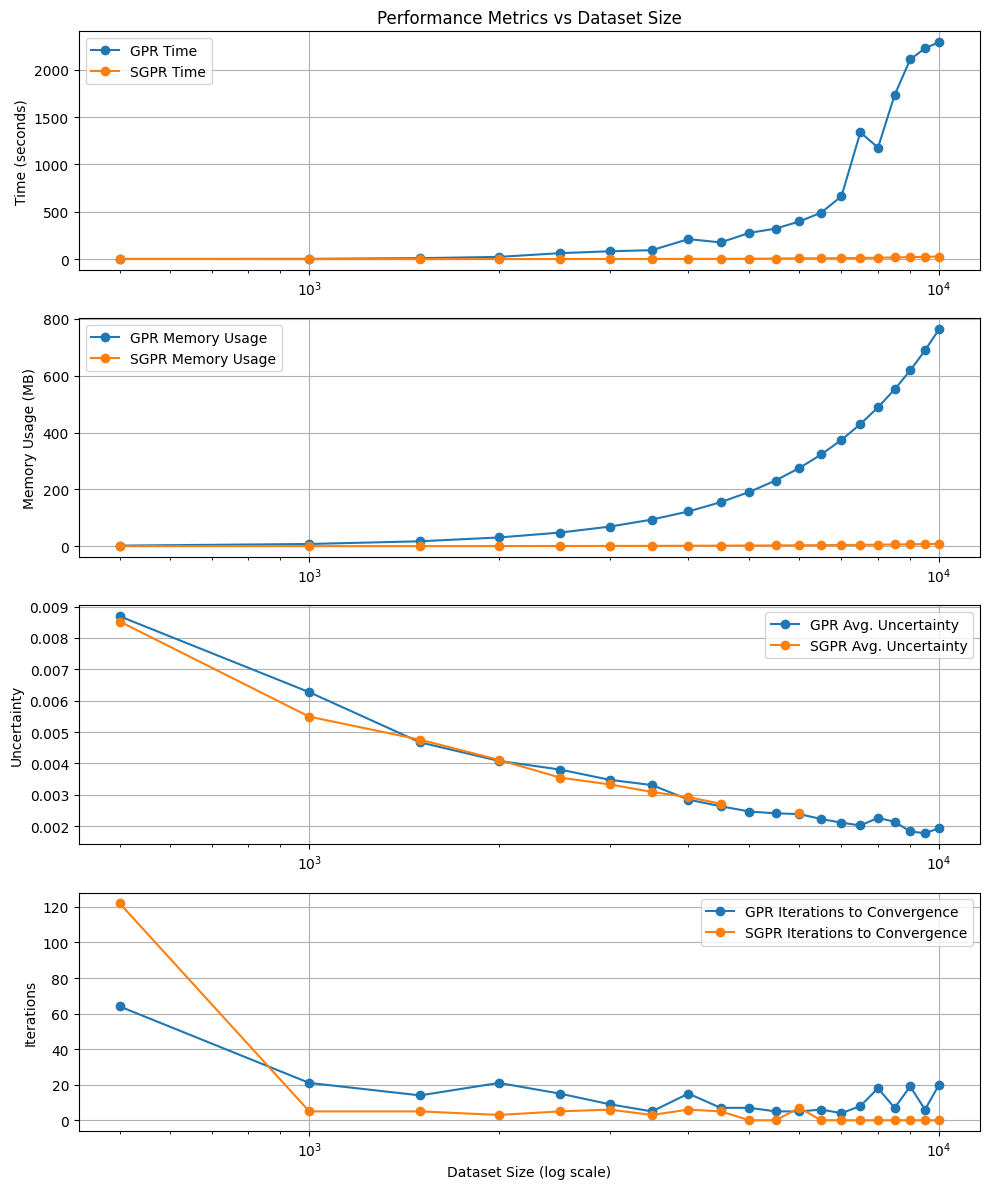

{'times': {'GPR': [2.227924108505249,
   3.049724817276001,
   10.400288105010986,
   23.668179988861084,
   62.940823793411255,
   83.0065050125122,
   94.53481531143188,
   211.47989296913147,
   176.21751284599304,
   277.8312978744507,
   321.54685401916504,
   397.59376406669617,
   490.78604888916016,
   664.0448470115662,
   1338.349133014679,
   1177.0381441116333,
   1731.066200017929,
   2107.8712248802185,
   2225.7442378997803,
   2289.9806530475616],
  'SGPR': [0.8792760372161865,
   0.36803197860717773,
   0.5497033596038818,
   0.6594529151916504,
   0.9882919788360596,
   1.715372085571289,
   1.6605887413024902,
   2.9878408908843994,
   2.9083359241485596,
   4.3717052936553955,
   5.547210931777954,
   9.09654712677002,
   8.479216814041138,
   10.290908813476562,
   12.6004638671875,
   14.940823078155518,
   17.57476305961609,
   21.01379895210266,
   24.14566397666931,
   27.71779990196228]},
 'uncertainties': {'GPR': [0.008689946653650572,
   0.00627008949482075,

In [12]:
models_kernels = [
    ("GPR", gpf.kernels.RBF(variance=1.0, lengthscales=1.0)),
    ("SGPR", gpf.kernels.RBF(variance=1.0, lengthscales=1.0))
]
# Run the comparison for these models
run_comparison(max_samples=10000, models_kernels=models_kernels)

